In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Fusion_net

/content/drive/MyDrive/Fusion_net


In [2]:
import torch
import torch.nn as nn
import cv2
from model_util import convbnrelu,image_CBR_2,image_CBR_3,depth_CBR_2,depth_CBR_3,dec_CBS3,dec_CBS2,FullyConnected
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
def read_image(path):
    img = cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def load_sparse_depth(input_sparse_depth_fp):
    input_sparse_depth = np.array(Image.open(input_sparse_depth_fp), dtype=np.float32)/256
    return input_sparse_depth


In [4]:
img = load_sparse_depth("/content/drive/MyDrive/Fusion_net/data/mmde_map/1686210162151891200.png")

In [5]:
img.shape

(720, 1280)

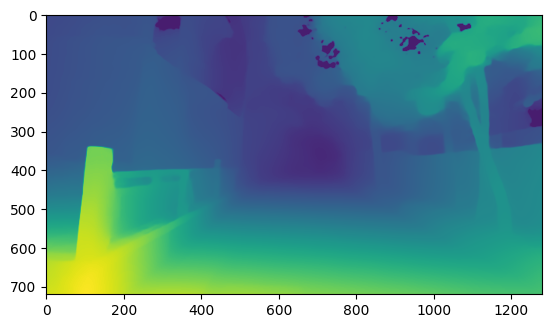

In [6]:
plt.imshow(img)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),])
transform_radar = transforms.Compose([
    transforms.ToTensor(),])

In [38]:
import os
import glob
class TrainDataLoader(Dataset):
    def __init__(self,
                 image_paths,
                 radar_paths,
                 radar_pcd_paths,
                 ground_truth_paths,transform):

        self.image_paths = glob.glob(os.path.join(image_paths, '*.*'))
        self.radar_paths = glob.glob(os.path.join(radar_paths, '*.*'))
        self.ground_truth_paths = glob.glob(os.path.join(ground_truth_paths, '*.*'))
        self.radar_pcd_paths = glob.glob(os.path.join(radar_pcd_paths, '*.*'))

        self.n_sample = len(self.image_paths)

        assert self.n_sample == len(self.ground_truth_paths)
        assert self.n_sample == len(self.radar_paths )
        assert self.n_sample == len(self.radar_pcd_paths)

        self.transform = transform
        self.transform_radar = transform_radar

    def process_radar_points(self,radar_points):
        '''
        Arg(s)
        radar_points (torch.Tensor): 1 x 1 x N x 3 (batch, channel, number of radar points, (x, y, z))

        Return(s)
        processed_points (torch.Tensor): 1 x 1 x 600 x 3 (batch, channel, 600 radar points, (x, y, z))
        '''
        # Set the target number of radar points
        target_num_points = 400

        # Get the current number of radar points
        num_points = radar_points.shape[0]

        if num_points > target_num_points:
            # Truncate to the first 600 points if there are more than 600
            radar_points = radar_points[:target_num_points, :]
        elif num_points < target_num_points:
            # Pad with zeros if there are fewer than 600 points
            padding = np.zeros((target_num_points - num_points, 3))
            radar_points = np.concatenate((radar_points, padding), axis=0)

        return radar_points


    def __len__(self):
        return self.n_sample

    def __getitem__(self,index):

        image = read_image(self.image_paths[index])
        height, width = image.shape[0], image.shape[1]
        if height == 720: # ZJU dataset
            image = image[720 // 3: 720 // 4 * 3,:,:]

        radar_img = load_sparse_depth(self.radar_paths[index])
        radar_img = radar_img/radar_img.max()
        if height == 720: # ZJU dataset
            radar_img = radar_img[720 // 3: 720 // 4 * 3, :]

        ground_truth = load_sparse_depth(self.ground_truth_paths[index])
        if height == 720:
          ground_truth = ground_truth[720 // 3: 720 // 4 * 3, :]
        #ground_truth = 1/(ground_truth+1e-8)

        radar_points = np.load(self.radar_pcd_paths[index])
        if radar_points.ndim == 1:
            radar_points = np.expand_dims(radar_points, axis=0)

        if height == 720:
            radar_points = radar_points[radar_points[:, 1] < 720 // 4 * 3]
            radar_points[:, 1] = radar_points[:, 1] - 720 // 3
            radar_points = radar_points[radar_points[:, 1] >= 0]
        radar_points = self.process_radar_points(radar_points)

        if self.transform:
            image = self.transform(image)
            radar_img = self.transform(radar_img)
            ground_truth = self.transform(ground_truth)
            radar_points = self.transform_radar(radar_points)
        image, radar_img,radar_points, ground_truth = [T.float() for T in [image, radar_img,radar_points, ground_truth]]


        return image, radar_img,radar_points, ground_truth

In [39]:
image_folder = "/content/drive/MyDrive/Fusion_net/data/image"
radar_path = "/content/drive/MyDrive/Fusion_net/data/mmde_map"
gt_path = "/content/drive/MyDrive/Fusion_net/data/gt_interp"
radar_pcd_path = "/content/drive/MyDrive/Fusion_net/data/radar"

In [40]:
dataset = TrainDataLoader(image_folder,radar_path,radar_pcd_path,gt_path,transform=transform)

In [41]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True,num_workers=0)

In [42]:
img,rad,radar_points,gt = next(iter(train_loader))

In [44]:
gt.max()

tensor(96.7137)

In [45]:
class depth_encoder(nn.Module):
    def __init__(self,in_channels = 1,out_channels = [64,128,256,512,512]):
        super(depth_encoder,self).__init__()

        self.layer_1 = depth_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = depth_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])
        self.layer_3 = depth_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = depth_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = depth_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])


    def forward(self,x):
        skip_latent = []

        x, skip = self.layer_1(x)
        skip_latent.append(skip)
        x, skip = self.layer_2(x)
        skip_latent.append(skip)
        x, skip = self.layer_3(x)
        skip_latent.append(skip)
        x, skip = self.layer_4(x)
        skip_latent.append(skip)
        _, skip = self.layer_5(x)
        skip_latent.append(skip)

        return skip_latent

In [46]:
class image_encoder(nn.Module):
    def __init__(self,in_channels = 3,out_channels = [64,128,256,512,512]):
        super(image_encoder,self).__init__()
        self.out_channels = out_channels

        self.layer_1 = image_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = image_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])

        self.layer_3 = image_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = image_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = image_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])

    def forward(self,x,skip_con,radar_skip):
        indices_list = list()
        image_lat_feat = list()
        x,indices,image_lat = self.layer_1(x,skip_con[0],radar_skip[0])
        indices_list.append(indices)
        image_lat_feat.append(x)
        x,indices,image_lat  = self.layer_2(x,skip_con[1],radar_skip[1])
        indices_list.append(indices)
        image_lat_feat.append(x)
        x,indices,image_lat  = self.layer_3(x,skip_con[2],radar_skip[2])
        indices_list.append(indices)
        image_lat_feat.append(x)
        x,indices,image_lat  = self.layer_4(x,skip_con[3],radar_skip[3])
        indices_list.append(indices)
        image_lat_feat.append(x)
        x,indices,image_lat  = self.layer_5(x,skip_con[4],radar_skip[4])
        indices_list.append(indices)
        image_lat_feat.append(x)

        return x,indices_list,image_lat_feat



In [47]:
class FullyConnectedEncoder(nn.Module):

    def __init__(self,
                 input_channels =3,
                 n_neuron = [64,128,256,512,512],
                 latent_size = [[224,224],[112,112],[56,56],[28,28],[14,14]]
                 ):
        super(FullyConnectedEncoder,self).__init__()
        self.n_neuron = n_neuron
        self.latent_size = latent_size
        self.fc_layer = nn.ModuleList([FullyConnected(in_features=input_channels *400, out_features = n_neuron[0]),
                                  FullyConnected(in_features=n_neuron[0],out_features = n_neuron[1]),
                                  FullyConnected(in_features=n_neuron[1],out_features = n_neuron[2]),
                                  FullyConnected(in_features=n_neuron[2],out_features = n_neuron[3]),
                                  FullyConnected(in_features=n_neuron[3],out_features = n_neuron[4])])

    def resize_radar_latent(self,radar_output,height,width):
        radar_output = radar_output.unsqueeze(2).unsqueeze(3).expand(-1,-1,height,width)
        return radar_output

    def forward(self,x):
        fully_skip_connect = list()
        x = x.view(1,-1)
        for idx,layer in enumerate(self.fc_layer):
            x = layer(x)
            fully_skip_connect.append(self.resize_radar_latent(x,self.latent_size[idx][0],self.latent_size[idx][1]))
        return x,fully_skip_connect

In [48]:
class decoder(nn.Module):
    def __init__(self,in_channels=512, out_channels=[512, 256, 128, 64]):
        super(decoder,self).__init__()
        self.dec_layer1 = dec_CBS3(in_channels=in_channels,out_channels=out_channels[0])
        self.dec_layer2 = dec_CBS3(in_channels=out_channels[0],out_channels=out_channels[1])
        self.dec_layer3 = dec_CBS2(in_channels=out_channels[1],out_channels=out_channels[2])
        self.dec_layer4 = dec_CBS2(in_channels=out_channels[2],out_channels=out_channels[3],dropout=False)
        self.dec_layer5 = dec_CBS2(in_channels=out_channels[3],out_channels=1,dropout=False)

    def forward(self,x,indices,image_lat_feat):
        x =  self.dec_layer1(x,indices = indices[4],output_size= indices[3].shape,img_latent =image_lat_feat[3]) # 14*14
        x =  self.dec_layer2(x,indices = indices[3],output_size= torch.Size([1,256,28,28]),img_latent =image_lat_feat[2]) # 28*28
        x =  self.dec_layer3(x,indices = indices[2],output_size= torch.Size([1,128,56,56]),img_latent =image_lat_feat[1]) # 56*56
        x =  self.dec_layer4(x,indices = indices[1],output_size= torch.Size([1,64,112,112]),img_latent =image_lat_feat[0]) # 112*112
        x =  self.dec_layer5(x,indices = indices[0],output_size= torch.Size([1,1,224,224]),img_latent = None) # 224*224

        return x

In [49]:
class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet,self).__init__()

        self.depth_encoder = depth_encoder()
        self.image_encoder = image_encoder()
        self.radar_encoder = FullyConnectedEncoder()
        self.fusion_decoder = decoder()

    def forward(self,input_image,input_depth_map,inpur_radar_pcd,):

        radar_output,radar_skip = self.radar_encoder(inpur_radar_pcd)
        #radar_output = radar_output.unsqueeze(2).unsqueeze(3).expand(-1,-1,7,7)
        skip = self.depth_encoder(input_depth_map)
        image_lat,indices_list,img_latent_feat = self.image_encoder(input_image,skip,radar_skip)
        #output = image_lat+radar_output
        depth_map = self.fusion_decoder(image_lat,indices_list,img_latent_feat)

        return depth_map


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
model = FusionNet()
model = model.to(device)

In [60]:

class ScaleInvariantLoss(nn.Module):
    def __init__(self):
        super(ScaleInvariantLoss, self).__init__()

    def forward(self, pred, target):
        # Ensure both pred and target are in log space
        log_diff = torch.log(pred) - torch.log(target)

        # First term: Mean of squared log differences
        term1 = torch.mean(log_diff ** 2)

        # Second term: Regularization to make the loss scale-invariant
        term2 = (torch.mean(log_diff)) ** 2

        # Scale-invariant loss
        loss = term1 - term2
        return loss

In [61]:
num_of_epochs = 1000
lr_rate = 0.001
momentum = 0.9
weight_decay = 0.0005

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [62]:
image = img.to(device)
rad_png = rad.to(device)
radar_points = radar_points.to(device)
ground_truth = gt.to(device)

In [63]:
for epoch in range(num_of_epochs):
  optimizer.zero_grad()
  depth_map = model(image,rad_png,radar_points)
  loss_value = loss(depth_map,ground_truth)
  loss_value.backward()
  optimizer.step()
  if epoch % 10 == 0:
    print(f"Epoch {epoch+1}, Loss: {loss_value}")


Epoch 1, Loss: 182.9394073486328
Epoch 11, Loss: 179.43963623046875
Epoch 21, Loss: 176.35250854492188
Epoch 31, Loss: 174.28085327148438
Epoch 41, Loss: 173.22755432128906
Epoch 51, Loss: 172.84378051757812
Epoch 61, Loss: 172.5063934326172
Epoch 71, Loss: 172.49851989746094
Epoch 81, Loss: 172.01364135742188
Epoch 91, Loss: 171.51881408691406
Epoch 101, Loss: 171.30267333984375
Epoch 111, Loss: 170.8167266845703
Epoch 121, Loss: 170.5843048095703
Epoch 131, Loss: 170.29408264160156
Epoch 141, Loss: 170.04615783691406
Epoch 151, Loss: 169.45411682128906
Epoch 161, Loss: 169.1850128173828
Epoch 171, Loss: 168.63021850585938
Epoch 181, Loss: 168.710693359375
Epoch 191, Loss: 168.10769653320312
Epoch 201, Loss: 167.90884399414062
Epoch 211, Loss: 167.4224090576172
Epoch 221, Loss: 166.97938537597656
Epoch 231, Loss: 166.4860076904297
Epoch 241, Loss: 165.8828887939453
Epoch 251, Loss: 164.94937133789062
Epoch 261, Loss: 164.31253051757812
Epoch 271, Loss: 164.17466735839844
Epoch 281, Lo

In [ ]:
img,rad,radar_points,gt = next(iter(train_loader))

In [64]:
image = img.to(device)
rad_png = rad.to(device)
radar_points = radar_points.to(device)
ground_truth = gt.to(device)

In [65]:
depth_map = model(image,rad_png,radar_points)

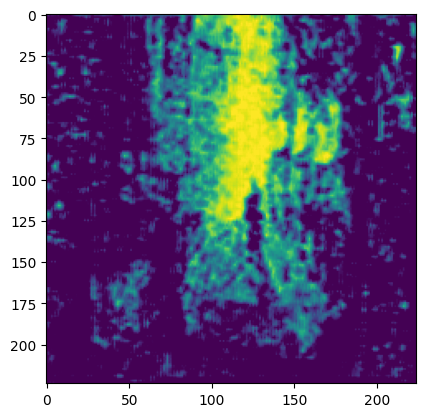

In [66]:
plt.imshow(depth_map[0].permute(1,2,0).detach().cpu().numpy())

In [67]:
depth_map.max()

tensor(6., device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
plt.imshow(img[0].permute(1,2,0).detach().cpu().numpy())

NameError: name 'plt' is not defined